## Data Preparation

In [28]:
import os
Root = "/kaggle/input/ravdess/"
os.chdir(Root)

In [29]:
ls

Actor_01/  Actor_05/  Actor_09/  Actor_13/  Actor_17/  Actor_21/
Actor_02/  Actor_06/  Actor_10/  Actor_14/  Actor_18/  Actor_22/
Actor_03/  Actor_07/  Actor_11/  Actor_15/  Actor_19/  Actor_23/
Actor_04/  Actor_08/  Actor_12/  Actor_16/  Actor_20/  Actor_24/


In [30]:
import os

# Initialize a variable to store the total number of samples
total_samples = 0

# Loop through subfolders in the main directory
for subfolder in os.listdir(Root):
    subfolder_path = os.path.join(Root, subfolder)
    if os.path.isdir(subfolder_path):
        # Count the number of files in the subfolder
        num_samples_in_subfolder = len(os.listdir(subfolder_path))
        total_samples += num_samples_in_subfolder

print("Total number of samples:", total_samples)


Total number of samples: 1440


# Importing Libraries

In [31]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [32]:
import pandas as pd
import numpy as np

##  <center> 1. Ravdess Dataframe <center>


In [33]:
ravdess_directory_list = os.listdir(Root)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Root + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Root + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess/Actor_02/03-01-08-01-01-...
1,neutral,/kaggle/input/ravdess/Actor_02/03-01-01-01-01-...
2,disgust,/kaggle/input/ravdess/Actor_02/03-01-07-02-01-...
3,disgust,/kaggle/input/ravdess/Actor_02/03-01-07-01-01-...
4,neutral,/kaggle/input/ravdess/Actor_02/03-01-01-01-02-...


In [34]:
print(len(file_path))

1440


In [35]:
# creating Dataframe using ravdees dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("/kaggle/working/data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess/Actor_02/03-01-08-01-01-...
1,neutral,/kaggle/input/ravdess/Actor_02/03-01-01-01-01-...
2,disgust,/kaggle/input/ravdess/Actor_02/03-01-07-02-01-...
3,disgust,/kaggle/input/ravdess/Actor_02/03-01-07-01-01-...
4,neutral,/kaggle/input/ravdess/Actor_02/03-01-01-01-02-...


## Data Visualisation and Exploration

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

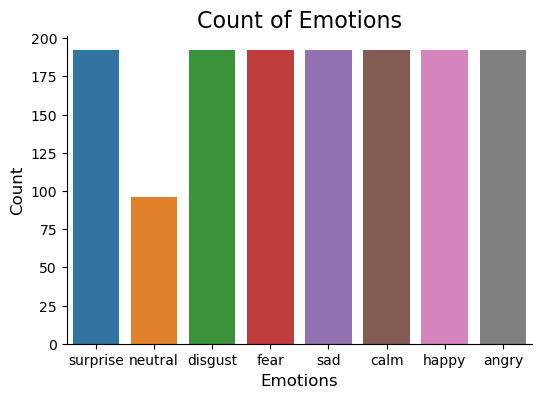

In [37]:
plt.figure(figsize=(6, 4))
plt.title('Count of Emotions', size=16)
sns.countplot(data=data_path, x='Emotions')
plt.xlabel('Emotions', size=12)
plt.ylabel('Count', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [38]:
import librosa
import librosa.display
from IPython.display import Audio

In [39]:
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    plt.plot(data)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

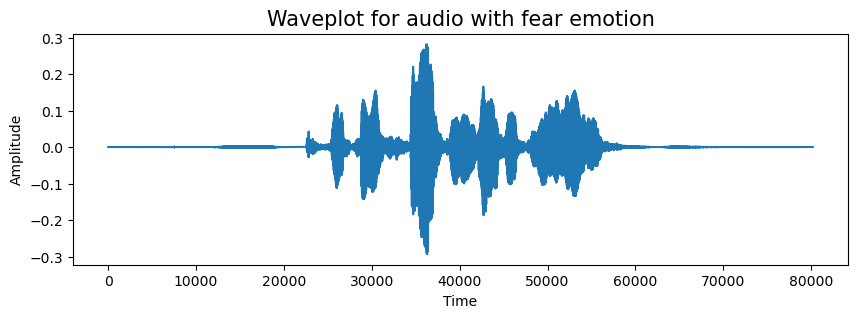

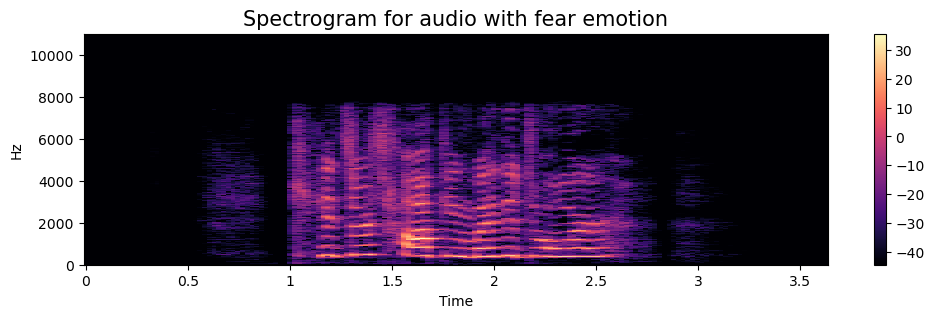

In [40]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation


In [41]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sr=22050, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

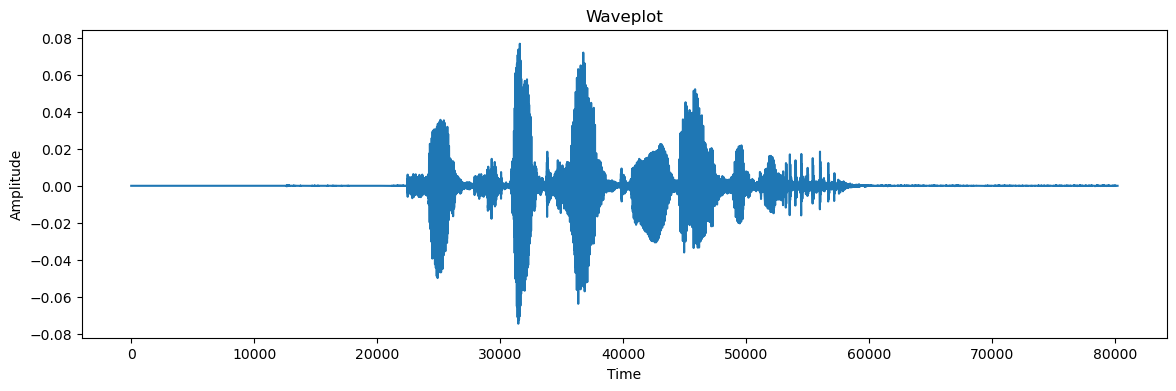

In [42]:
plt.figure(figsize=(14, 4))
plt.plot(data)
plt.title('Waveplot')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Audio(path)

#### 2. Noise Injection

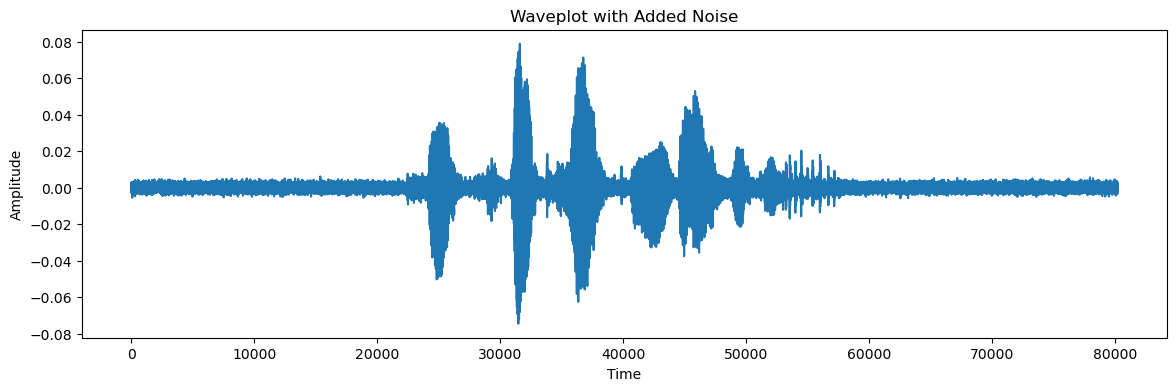

In [43]:
# x = np.random.normal(0, 0.1, len(data)) + data  # Add noise to the data

x = noise(data)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Waveplot with Added Noise')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sample_rate)

#### 3. Stretching

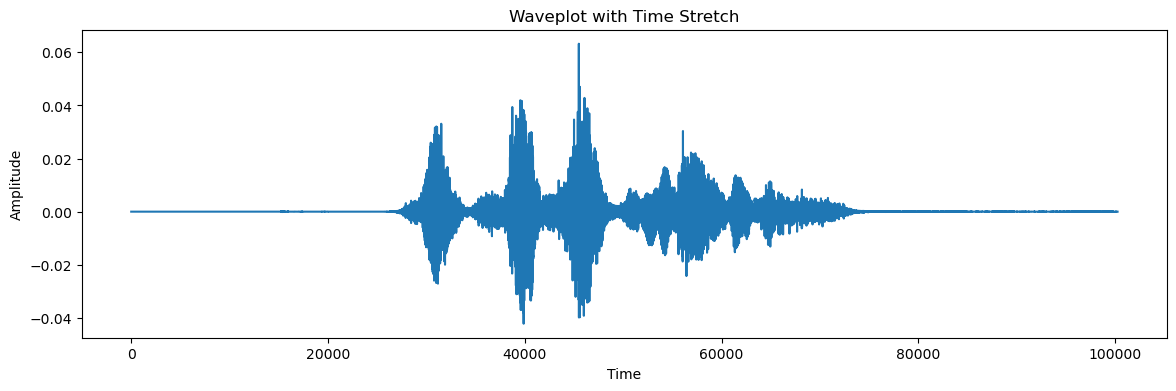

In [44]:
x = stretch(data, rate=0.8)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Waveplot with Time Stretch')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sample_rate)

#### 4. Shifting

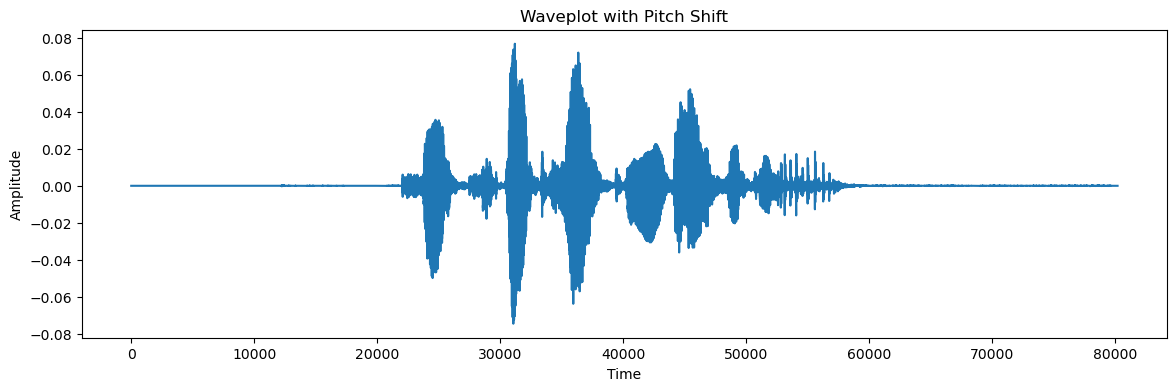

In [45]:
x = shift(data)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Waveplot with Pitch Shift')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sample_rate)

#### 5. Pitch

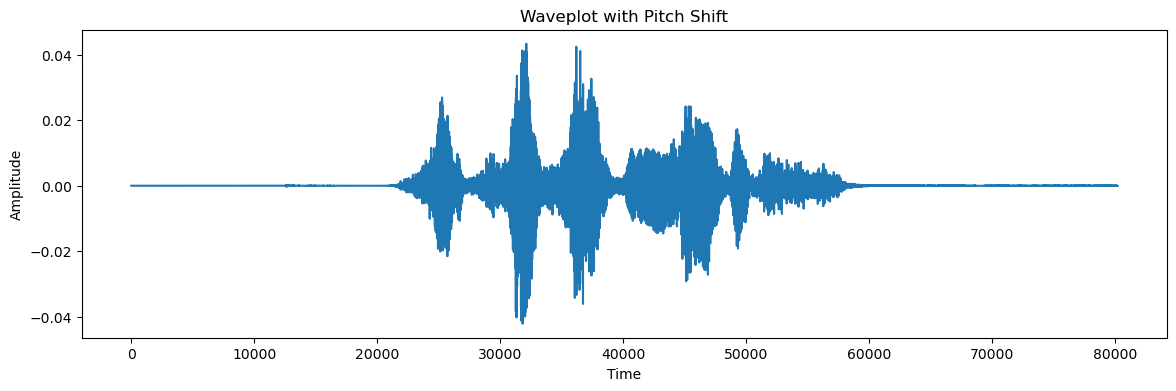

In [46]:
x = pitch(data, sr=22050, n_steps=2)
plt.figure(figsize=(14,4))
plt.plot(x)
plt.title('Waveplot with Pitch Shift')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [47]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with shift
    shift_data = shift(data)
    res3 = extract_features(shift_data)
    result = np.vstack((result, res3)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res4 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res4)) # stacking vertically
    
    return result

In [48]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [49]:
num_samples = len(X)
num_time_steps = X[0].shape[0]  # Assuming all features have the same length
num_frequency_bins = 1  # 1D audio data has only one frequency bin

print("Number of samples:", num_samples)
print("Number of time steps:", num_time_steps)
print("Number of frequency bins:", num_frequency_bins)

Number of samples: 5760
Number of time steps: 162
Number of frequency bins: 1


In [50]:
len(X), len(Y), data_path.Path.shape

(5760, 5760, (1440,))

In [51]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('/kaggle/working/features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.214034,0.631756,0.623948,0.568991,0.528665,0.538974,0.655633,0.691172,0.691927,0.696634,...,3.701281e-14,2.976536e-14,2.442510e-14,2.098411e-14,1.866825e-14,1.699130e-14,1.669633e-14,1.616639e-14,1.504322e-14,surprise
1,0.336887,0.732049,0.755171,0.733772,0.718682,0.744679,0.738408,0.718695,0.694772,0.699210,...,1.333310e-03,1.357042e-03,1.295455e-03,1.291843e-03,1.370210e-03,1.275611e-03,1.310639e-03,1.278015e-03,1.298871e-03,surprise
2,0.214346,0.636652,0.617276,0.564281,0.526371,0.580869,0.681275,0.703203,0.702766,0.710469,...,8.064924e-14,6.371200e-14,5.232132e-14,4.481628e-14,3.967260e-14,3.601030e-14,3.432059e-14,3.286810e-14,3.120196e-14,surprise
3,0.180490,0.743045,0.709265,0.644338,0.642090,0.567635,0.512175,0.523160,0.656041,0.690112,...,2.476184e-06,4.517289e-09,2.355559e-14,1.332394e-14,9.743944e-15,9.747400e-15,6.472294e-15,3.730383e-15,7.668983e-16,surprise
4,0.203695,0.560744,0.541266,0.568667,0.605067,0.601439,0.616136,0.667533,0.719400,0.699431,...,3.263752e-14,2.590154e-14,2.146551e-14,1.837098e-14,1.624641e-14,1.472064e-14,1.400520e-14,1.316642e-14,1.273888e-14,neutral


* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [52]:
# print(X, Y)

In [53]:
# df = pd.DataFrame({'A':[1,2,3],
#                    'B':[4,5,6],
#                    'C':[7,8,9],
#                    'D':[1,3,5],
#                    'E':[5,3,6],
#                    'F':[7,4,3]})

# print (df)
#    A  B  C  D  E  F
# 0  1  4  7  1  5  7
# 1  2  5  8  3  3  4
# 2  3  6  9  5  6  3

# print(df.iloc[:, :-1])
#    A  B  C  D  E
# 0  1  4  7  1  5
# 1  2  5  8  3  3
# 2  3  6  9  5  6

# X = df.iloc[:, :-1].values
# print (X)
# [[1 4 7 1 5]
#  [2 5 8 3 3]
#  [3 6 9 5 6]]

# print (X.shape)
# (3, 5)


# # Single selections using iloc and DataFrame
# # Rows:
# data.iloc[0] # first row of data frame (Aleshia Tomkiewicz) - Note a Series data type output.
# data.iloc[1] # second row of data frame (Evan Zigomalas)
# data.iloc[-1] # last row of data frame (Mi Richan)
# # Columns:
# data.iloc[:,0] # first column of data frame (first_name)
# data.iloc[:,1] # second column of data frame (last_name)
# data.iloc[:,-1] # last column of data frame (id)

In [54]:
# X = Features.iloc[: ,:-1].values
X = np.array(Features.iloc[:, :-1].values).reshape(num_samples, num_time_steps, num_frequency_bins, 1)
Y = Features['labels'].values

In [55]:
print(X, Y)

[[[[2.14034469e-01]]

  [[6.31756067e-01]]

  [[6.23947918e-01]]

  ...

  [[1.66963323e-14]]

  [[1.61663895e-14]]

  [[1.50432154e-14]]]


 [[[3.36886936e-01]]

  [[7.32049458e-01]]

  [[7.55171012e-01]]

  ...

  [[1.31063902e-03]]

  [[1.27801499e-03]]

  [[1.29887124e-03]]]


 [[[2.14346427e-01]]

  [[6.36652231e-01]]

  [[6.17275536e-01]]

  ...

  [[3.43205892e-14]]

  [[3.28681039e-14]]

  [[3.12019596e-14]]]


 ...


 [[[3.07522244e-01]]

  [[7.26505531e-01]]

  [[7.55786255e-01]]

  ...

  [[3.25512685e-02]]

  [[3.40461112e-02]]

  [[3.47673385e-02]]]


 [[[1.33142542e-01]]

  [[6.20676935e-01]]

  [[6.18393660e-01]]

  ...

  [[6.07414397e-11]]

  [[6.08604070e-11]]

  [[6.08160050e-11]]]


 [[[1.68652344e-01]]

  [[6.55604243e-01]]

  [[5.74435472e-01]]

  ...

  [[2.31833178e-10]]

  [[1.96568095e-10]]

  [[6.65258126e-11]]]] ['surprise' 'surprise' 'surprise' ... 'angry' 'angry' 'angry']


In [56]:
from sklearn.preprocessing import OneHotEncoder


In [57]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [58]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 162, 1, 1), (4608, 8), (1152, 162, 1, 1), (1152, 8))

In [59]:
from sklearn.preprocessing import StandardScaler


In [60]:
# Reshape the data to 2D
x_train_2d = x_train.reshape(x_train.shape[0], -1)
x_test_2d = x_test.reshape(x_test.shape[0], -1)

# Apply StandardScaler to the 2D data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_2d)
x_test_scaled = scaler.transform(x_test_2d)

# Reshape the scaled data back to 3D
x_train = x_train_scaled.reshape(x_train.shape[0], num_time_steps, num_frequency_bins, 1)
x_test = x_test_scaled.reshape(x_test.shape[0], num_time_steps, num_frequency_bins, 1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


((4608, 162, 1, 1), (4608, 8), (1152, 162, 1, 1), (1152, 8))

In [61]:
# # scaling our data with sklearn's Standard scaler
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [62]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 162, 1, 1), (4608, 8), (1152, 162, 1, 1), (1152, 8))

In [63]:
# Dorkar nai


# # making our data compatible to model.
# x_train = np.expand_dims(x_train, axis=4)
# x_test = np.expand_dims(x_test, axis=4)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

## Modelling

In [64]:
# import keras
# from keras.callbacks import ReduceLROnPlateau
# from keras.models import Sequential
# from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
# from keras.callbacks import ModelCheckpoint

In [65]:
import keras
from keras.layers import Input, Dense, Dropout, Flatten, Conv3D, MaxPool3D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
# from faces import face_samples
import numpy as np

In [66]:
# model=Sequential()
# model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
# model.add(Dropout(0.2))

# model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

# model.add(Flatten())
# model.add(Dense(units=32, activation='relu'))
# model.add(Dropout(0.3))

# model.add(Dense(units=8, activation='softmax'))
# model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

# model.summary()

In [67]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization

num_samples = 1440
num_time_steps = 162
num_frequency_bins = 1
num_channels = 1  # Single-channel audio

model = Sequential()

# First Conv3D layer
model.add(Conv3D(64, kernel_size=(3, 1, 1), activation='relu', input_shape=(num_time_steps, num_frequency_bins, num_channels, 1)))
model.add(MaxPooling3D(pool_size=(2, 1, 1), strides=(2, 1, 1)))

# Second Conv3D layer
model.add(Conv3D(128, kernel_size=(3, 1, 1), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 1, 1), strides=(2, 1, 1)))

# Third Conv3D layer
model.add(Conv3D(256, kernel_size=(3, 1, 1), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 1, 1), strides=(2, 1, 1)))

# Flatten layer
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))

# Dense layer
model.add(Dense(8, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 160, 1, 1, 64)     256       
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 80, 1, 1, 64)     0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 78, 1, 1, 128)     24704     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 39, 1, 1, 128)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 37, 1, 1, 256)     98560     
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 18, 1, 1, 256)   

In [68]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [69]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
72/72 [==============================] - 19s 242ms/step - loss: 1.8737 - accuracy: 0.2654 - val_loss: 1.7282 - val_accuracy: 0.3802 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 17s 239ms/step - loss: 1.6294 - accuracy: 0.3815 - val_loss: 1.4990 - val_accuracy: 0.4280 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 17s 238ms/step - loss: 1.4758 - accuracy: 0.4460 - val_loss: 1.3773 - val_accuracy: 0.4965 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 17s 238ms/step - loss: 1.3625 - accuracy: 0.4933 - val_loss: 1.2729 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 17s 233ms/step - loss: 1.2480 - accuracy: 0.5343 - val_loss: 1.1745 - val_accuracy: 0.5781 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - 17s 237ms/step - loss: 1.1339 - accuracy: 0.5799 - val_loss: 1.0884 - val_accuracy: 0.6016 - lr: 0.0010
Epoch 7/50
72/72 [==============================] - 17s 238ms/st

36/36 [==============================] - 1s 14ms/step - loss: 0.8618 - accuracy: 0.8255
Accuracy of our model on test data :  82.55208134651184 %


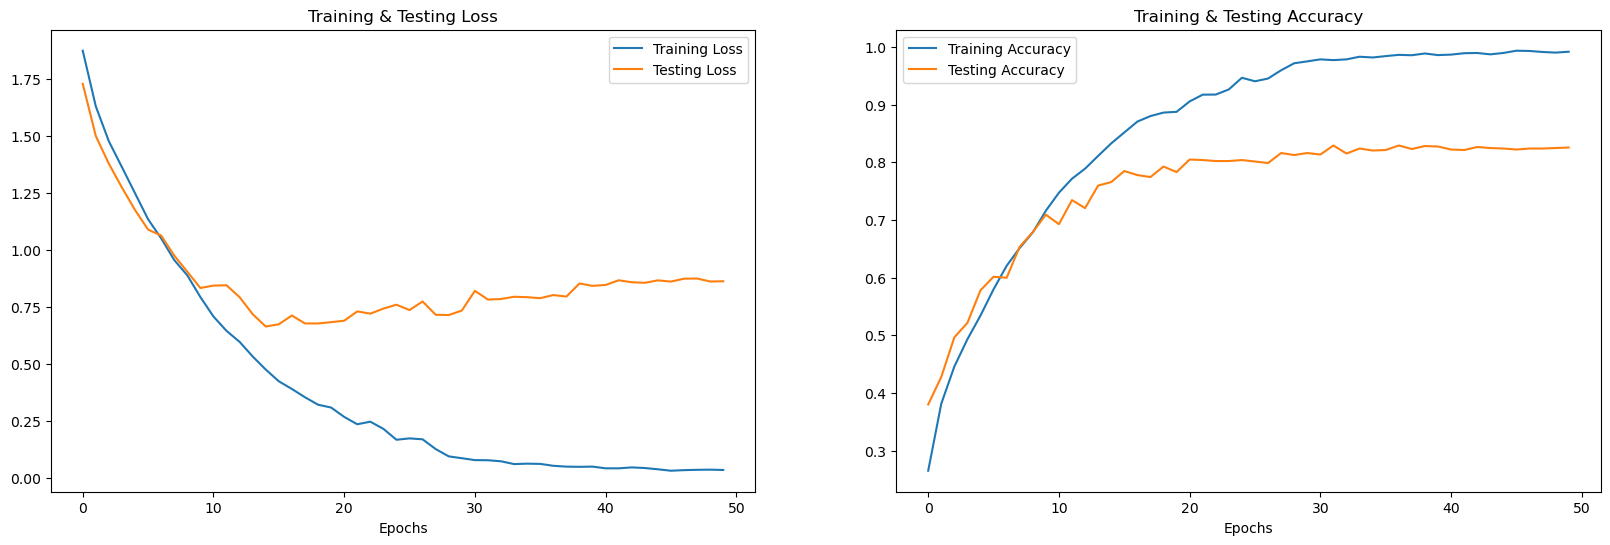

In [70]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [71]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

36/36 [==============================] - 1s 13ms/step


In [72]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,sad,sad
1,fear,fear
2,angry,disgust
3,fear,happy
4,surprise,surprise
5,sad,sad
6,calm,calm
7,calm,calm
8,calm,calm
9,neutral,neutral


In [73]:
from sklearn.metrics import confusion_matrix


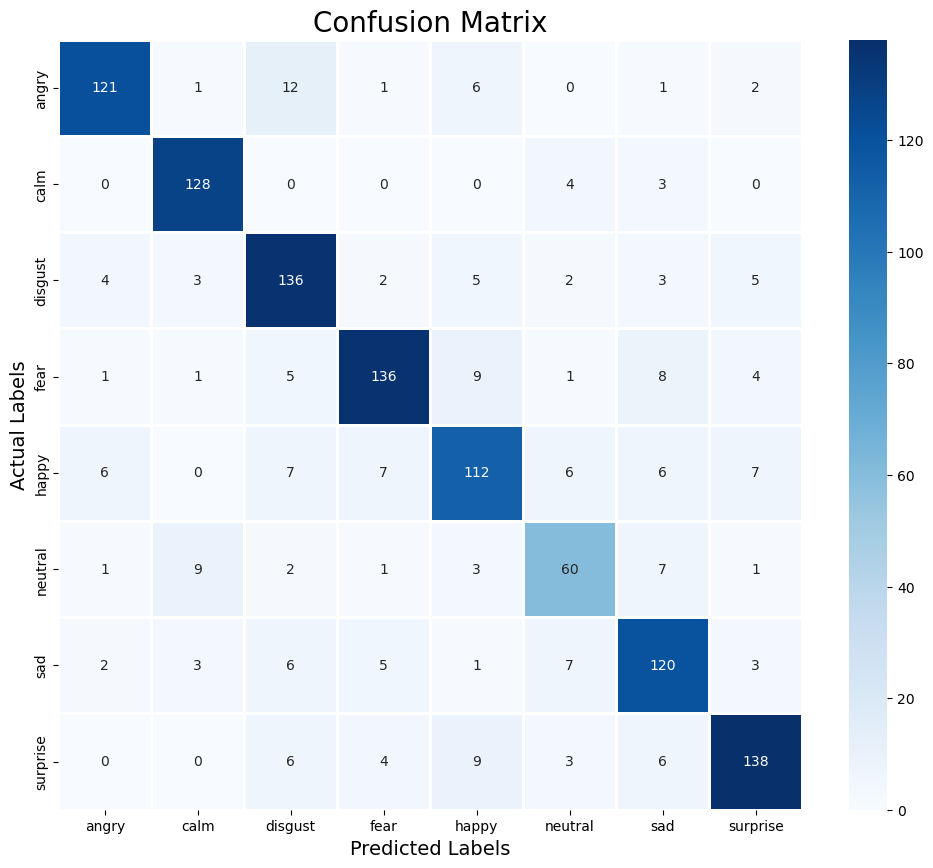

In [74]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [75]:
from sklearn.metrics import classification_report

In [76]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

       angry       0.90      0.84      0.87       144
        calm       0.88      0.95      0.91       135
     disgust       0.78      0.85      0.81       160
        fear       0.87      0.82      0.85       165
       happy       0.77      0.74      0.76       151
     neutral       0.72      0.71      0.72        84
         sad       0.78      0.82      0.80       147
    surprise       0.86      0.83      0.85       166

    accuracy                           0.83      1152
   macro avg       0.82      0.82      0.82      1152
weighted avg       0.83      0.83      0.83      1152



# DEMO

In [77]:
def extract_feature(file_name, mfcc=True, chroma=True, mel=True):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            stft=np.abs(librosa.stft(X))
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result


In [78]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised',
  '09':'very happy' # new emotion
}

#Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [79]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/kaggle/input/ravdess/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [80]:
#Split the dataset
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

In [81]:
x_train

array([[-6.63409851e+02,  6.28907242e+01,  6.79316700e-01, ...,
         2.10602002e-06,  1.07944129e-06,  4.10197487e-07],
       [-7.19731262e+02,  5.00171280e+01,  1.93986588e+01, ...,
         4.06073241e-06,  1.23240511e-06,  5.81108509e-07],
       [-5.92325684e+02,  3.48012199e+01, -1.67392044e+01, ...,
         5.40780129e-05,  3.11042058e-05,  2.10854214e-05],
       ...,
       [-5.03494232e+02,  1.91213112e+01, -1.31133118e+01, ...,
         2.97791994e-04,  1.04964252e-04,  9.26514476e-05],
       [-7.00927124e+02,  3.72501717e+01, -1.51359141e+00, ...,
         1.36875169e-05,  8.43393445e-06,  4.48950686e-06],
       [-5.90802185e+02,  5.89666595e+01, -1.06967535e+01, ...,
         5.97229482e-05,  2.71564131e-05,  1.30416247e-05]])

In [82]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

(576, 192)


In [83]:
#Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [84]:
#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [85]:
#Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [86]:
#Predict for the test set
y_pred=model.predict(x_test)

In [87]:
y_pred

array(['happy', 'calm', 'disgust', 'disgust', 'happy', 'happy', 'happy',
       'happy', 'happy', 'calm', 'disgust', 'happy', 'fearful', 'calm',
       'calm', 'happy', 'happy', 'calm', 'happy', 'calm', 'calm', 'happy',
       'disgust', 'happy', 'happy', 'calm', 'fearful', 'happy', 'happy',
       'calm', 'happy', 'happy', 'happy', 'happy', 'calm', 'calm', 'calm',
       'happy', 'disgust', 'happy', 'fearful', 'disgust', 'fearful',
       'disgust', 'happy', 'calm', 'happy', 'calm', 'disgust', 'disgust',
       'calm', 'happy', 'calm', 'disgust', 'happy', 'happy', 'calm',
       'happy', 'happy', 'happy', 'happy', 'calm', 'calm', 'calm',
       'disgust', 'happy', 'calm', 'happy', 'happy', 'fearful', 'calm',
       'fearful', 'disgust', 'fearful', 'calm', 'disgust', 'happy',
       'disgust', 'disgust', 'disgust', 'fearful', 'calm', 'fearful',
       'calm', 'fearful', 'disgust', 'fearful', 'calm', 'calm', 'calm',
       'disgust', 'happy', 'fearful', 'happy', 'disgust', 'calm', 'calm

In [88]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 72.40%


In [89]:
from sklearn.metrics import accuracy_score, f1_score

In [90]:
f1_score(y_test, y_pred,average=None)

array([0.88659794, 0.73809524, 0.62068966, 0.65517241])

In [91]:
import pandas as pd
df=pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df.head(20)

,Actual,Predicted
0,fearful,happy
1,calm,calm
2,disgust,disgust
3,disgust,disgust
4,calm,happy
5,fearful,happy
6,happy,happy
7,fearful,happy
8,fearful,happy
9,calm,calm


In [92]:
import pickle
# Writing different model files to file
with open( 'my_models/modelForPrediction1.sav', 'wb') as f:
    pickle.dump(model,f)

FileNotFoundError: [Errno 2] No such file or directory: 'my_models/modelForPrediction1.sav'

In [ ]:
filename = 'my_models/modelForPrediction1.sav'
loaded_model = pickle.load(open(filename, 'rb')) # loading the model file from the storage

feature=extract_feature("/kaggle/input/ravdess/Actor_01/03-01-01-01-01-01-01.wav", mfcc=True, chroma=True, mel=True)

feature=feature.reshape(1,-1)

prediction=loaded_model.predict(feature)
prediction

In [ ]:
feature